# Factor model

In [1]:
%load_ext autoreload
%autoreload 1

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from edward.models import Normal, Uniform, StudentT
from edward.models import RandomVariable
from tensorflow.contrib.distributions import Distribution

from factorAnalysisKLqp import *
from plot_utils import *

In [2]:
# note that in the function below D should be greater then K
def build_toy_dataset(N, D, K):
    x_train = np.zeros([D, N])
    w = np.zeros([D,K])
    for k in range(K):
        w[k,k]=3.0/(k+1)
        w[k+1,k]=-3.0/(k+1)
    w *= 3
    print(w)
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    shift=np.zeros([D])
    shift[0]=10
    shift[1]=23
    sigma = np.abs(np.random.normal(size=D))+0.1
    for d in range(D):
      for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma[d])+shift[d]
#     print("True principal axes:")
#     print(w)
#     print("Shift:")
#     print(shift)
    return x_train.astype(np.float32,copy=False), w, shift, sigma


#ed.set_seed(142)

N = 1000  # number of data points
D = 6  # data dimensionality
K = 5 # latent dimensionality

# DATA

x_train, w_true, shift, sigma_true = build_toy_dataset(N, D, K)

[[ 9.    0.    0.    0.    0.  ]
 [-9.    4.5   0.    0.    0.  ]
 [ 0.   -4.5   3.    0.    0.  ]
 [ 0.    0.   -3.    2.25  0.  ]
 [ 0.    0.    0.   -2.25  1.8 ]
 [ 0.    0.    0.    0.   -1.8 ]]


In [3]:
halfCauchy = StudentT(df=1., loc=0., scale=1.)

In [4]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    tmp = halfCauchy.sample(10000).eval()

In [5]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

In [6]:
import bijectors as bijector

In [7]:
shift

array([ 10.,  23.,   0.,   0.,   0.,   0.])

In [8]:
sigma_true

array([ 0.39490553,  0.12872733,  1.11636771,  1.04174827,  0.56857746,
        0.12110645])

## P-model

\begin{align}
i \in {1,...,D}\\
j \in {1,...,K}\\
n \in {1,...,N}\\
\tau &\sim StudentT(1,0)\\
\lambda_j &\sim StudentT(1,0)\\
w_{ij}&\sim N(0,|\tau||\lambda_j|)\\
z_{jn}&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma_i &\sim Gamma(1,1)\\
x_i&\sim N((w\cdot z)_i+\mu_i,\sigma_i)\\
\end{align}

### The automatic relevance determination in higher dimensions

The ARD might seem like an overkill but it comes in handy in higher dimensions, where the dimensionality of the latent space is not a prior known.  Let us generate a higher dimensional data set and see how ARD determines the latent dimensionality.

In [9]:
# P MODEL

K=D

sigma = ed.models.Gamma(tf.ones([D])*0.1,tf.ones([D])*0.1)

#alpha = ed.models.Gamma(tf.ones([K])*0.002,tf.ones([K])*0.002)
lamda = StudentT(df=1., loc=tf.zeros([K]), scale=tf.ones([K]))
tau = StudentT(df=1., loc=0., scale=1.)
w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(np.abs(tau)*np.abs(lamda),[D]),[D,K]))
z = Normal(tf.zeros([N, K]),    tf.ones([N, K]))
#z = Normal(tf.zeros([K, N]),    tf.ones([K, N]))
mu = Normal(tf.zeros([D]),       tf.ones([D]))
#x = ed.models.MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z)),mu), tf.reshape(tf.tile(sigma,[N]),[N,D]))
x = ed.models.MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z, transpose_b=True)),mu), tf.reshape(tf.tile(sigma,[N]),[N,D]))

In [10]:
# Q MODEL
qtau = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([])),
                                                   tf.Variable(tf.random_normal([]))),
    bijector=bijector.Exp(),
    name="qtau")
qlamda = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([K])),
                                                   tf.Variable(tf.random_normal([K]))),
    bijector=bijector.Exp(),
    name="qlamda")
# so far, only log-normals work
#qlamda = StudentT(df=1., loc=tf.Variable(tf.random_normal([K])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
#qtau = StudentT(df=1., loc=tf.Variable(tf.random_normal([])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

qw = Normal(tf.Variable(tf.random_normal([D, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(tf.Variable(tf.random_normal([N, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

# initial conditions for qmu, improves convergence
data_mean = np.mean(x_train,axis=1).astype(np.float32,copy=False)

qmu = Normal(tf.Variable(data_mean+tf.random_normal([D])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qsigma = ed.models.TransformedDistribution(
#    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
#                                  tf.Variable(tf.ones(D))),
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([D])),
                                  tf.Variable(tf.random_normal([D]))),
    bijector=bijector.Exp(),
    name="qsigma")

#inference = ed.KLqp({alpha: qalpha, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_high.T})
#inference.run(n_iter=4000, n_samples=20)

#print("Inferred principal axes (columns):")
#print(qw.mean().eval())
#print(qw.variance().eval())
#print("Inferred center:")
#print(qmu.mean().eval())
#print(qmu.variance().eval())

In [11]:
#inference3 = ed.KLqp({alpha: qalpha, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_train.T})
inference3 = ed.KLqp({lamda: qlamda, tau: qtau, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_train.T})
inference3.initialize(n_iter=1000, n_print=1000, n_samples=10, optimizer='rmsprop')

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [12]:
learning_curve3 = []
for _ in range(inference3.n_iter):
    info_dict = inference3.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve3.append(info_dict['loss'])
plt.semilogy(learning_curve3)

{'loss': 1297927.6, 't': 1}


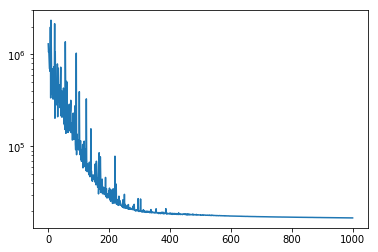

In [13]:
plt.show()

In [14]:
learning_curve3[-1]

16772.645

In [15]:
x_sim = ed.copy(x, {lamda: qlamda, tau: qtau, w: qw, z: qz, mu: qmu, sigma: qsigma})

In [16]:
pd.DataFrame(np.round(qw.mean().eval(),1))

,0,1,2,3,4,5
0,-0.0,3.0,0.0,0.8,-7.2,0.0
1,0.0,-3.3,3.5,0.8,7.0,0.0
2,-0.0,0.2,-5.2,-0.1,0.8,-0.0
3,0.0,1.5,1.8,-2.1,0.2,0.0
4,0.0,-2.9,-0.2,-0.2,-1.7,0.0
5,0.0,0.9,0.0,0.5,0.5,-0.0


In [17]:
qw.mean()

<tf.Tensor 'Normal_4/mean_1/mul:0' shape=(6, 6) dtype=float32>

In [18]:
w_tmp = np.ones((D,D))*10**(-10)
w_tmp[:K,:5] = w_true

In [19]:
qwmode = qw.mode().eval()

In [20]:
np.max(qwmode),np.min(qwmode)

(6.9756222, -7.192575)

In [21]:
np.max(w_tmp), np.min(w_tmp)

(9.0, -9.0)

In [22]:
shift

array([ 10.,  23.,   0.,   0.,   0.,   0.])

In [23]:
qmu.mean().eval()

array([  1.11769800e+01,   2.15465279e+01,   1.81088597e-01,
        -3.60776037e-02,   2.91276500e-02,   3.54353758e-03], dtype=float32)

In [24]:
sigma_true

array([ 0.41435794,  0.65096613,  0.56905162,  0.19845573,  1.86918482,
        1.07888733])

In [25]:
qsigma.get_variables()[0].eval()

array([-3.78555775, -3.82583427, -3.77476096, -3.74018693, -3.79639363,
       -3.77440739], dtype=float32)

In [26]:
foo = sorted(np.exp(qsigma.get_variables()[0].eval()))

In [27]:
foo

[0.021800241, 0.022451594, 0.022696201, 0.022942575, 0.022950688, 0.023749663]

In [28]:
tmp = qw.mean().eval()

In [29]:
tmp[abs(tmp)>0.05]

array([ 2.95105243,  0.79256606, -7.19257498, -3.33481574,  3.49418402,
        0.8459664 ,  6.97562218,  0.16847275, -5.20133543, -0.05890445,
        0.78457725,  1.47897708,  1.76969659, -2.08433986,  0.2268773 ,
       -2.89192057, -0.21547233, -0.1563589 , -1.67773688,  0.88104987,
        0.49718678,  0.4967671 ], dtype=float32)

alphas=tf.exp(qalpha.distribution.mean()).eval()
alphas.sort()
plt.plot(range(alphas.size),alphas)
plt.show()

plt.hist(qalpha.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()

In [30]:
qsigma.get_variables()[0].eval()

array([-3.78555775, -3.82583427, -3.77476096, -3.74018693, -3.79639363,
       -3.77440739], dtype=float32)

In [31]:
x_sim_sample = x_sim.sample().eval()

In [32]:
x_true_and_sim = pd.DataFrame(np.c_[np.r_[x_train.T,x_sim_sample],np.r_[np.zeros(N),np.ones(N)]])

In [33]:
names = 'abcdefghijk'[:D+1]

In [34]:
x_true_and_sim.columns = [i for i in names]

In [35]:
sns.set()
scattermatrix = sns.pairplot(x_true_and_sim, hue=names[-1], diag_kind= 'kde', vars = [i for i in names[:-1]])#, plot_kws=dict(alpha=.2))

In [36]:
[ax.set_ylim(-40,40) for ax in scattermatrix.axes.flatten()]
[ax.set_xlim(-40,40) for ax in scattermatrix.axes.flatten()];
#[axes.set_xlim(-40,40) for axes in scattermatrix.axes]

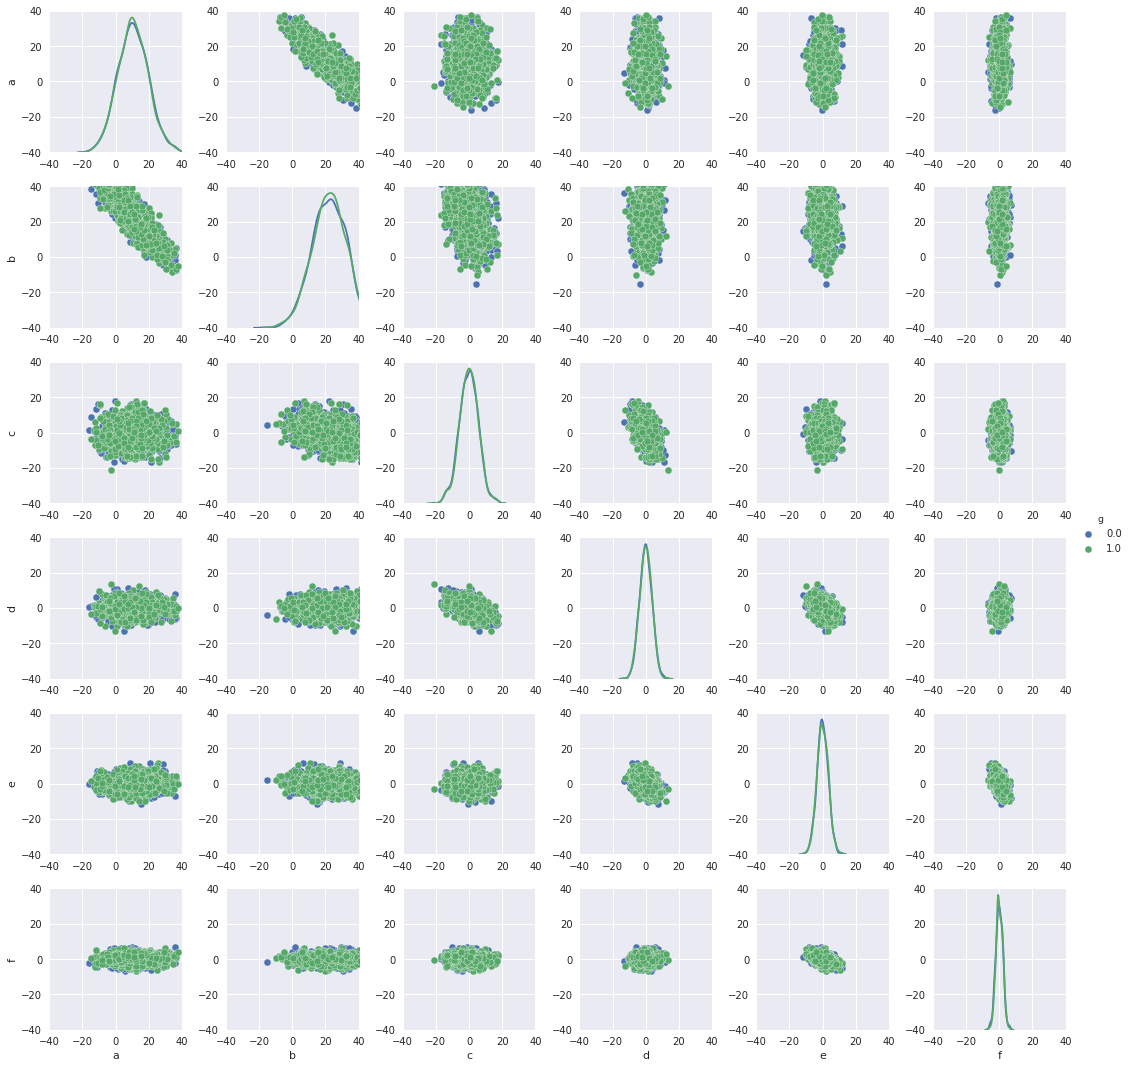

In [37]:
plt.show()

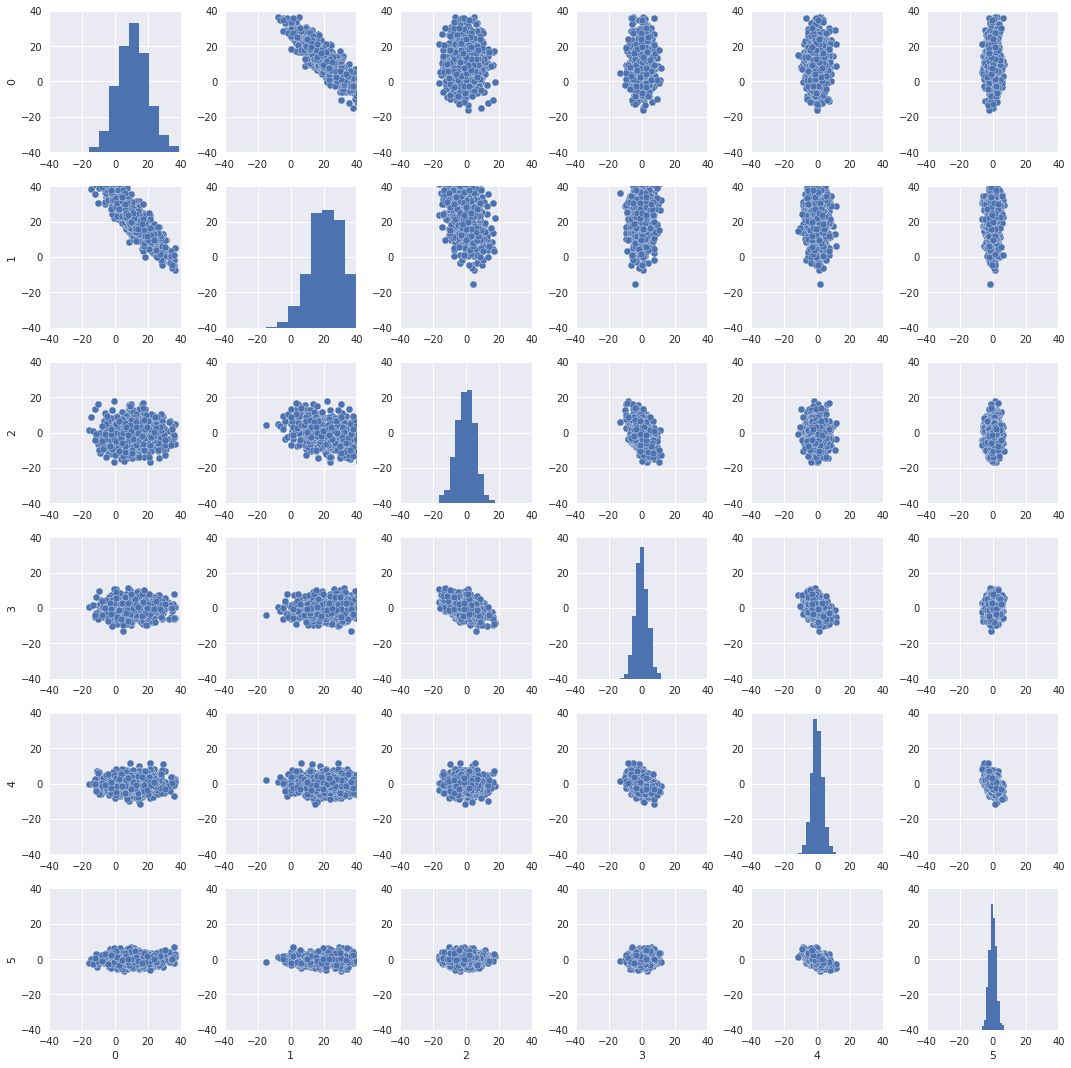

In [38]:
scattermatrix2 = sns.pairplot(pd.DataFrame(x_train.T))
[ax.set_ylim(-40,40) for ax in scattermatrix2.axes.flatten()]
[ax.set_xlim(-40,40) for ax in scattermatrix2.axes.flatten()];
plt.show()

In [9]:
x_train = x_train.T

In [10]:
M = 100
student = low_rank_mvn_horseshoe_ard(N,M,D)
#student.initialize(x_train)

{'loss': 156777.44, 't': 101}
{'loss': 41463.453, 't': 201}
{'loss': 27981.684, 't': 301}
{'loss': 27476.918, 't': 401}
{'loss': 25539.9, 't': 501}
{'loss': 24034.467, 't': 601}
{'loss': 21482.025, 't': 701}
{'loss': 19248.334, 't': 801}
{'loss': 16709.807, 't': 901}
{'loss': 13349.577, 't': 1001}


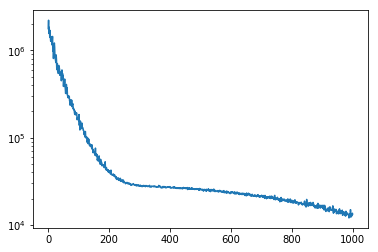

In [11]:
#student.infer(x_train, n_epoch = 1000, n_samples = 10)
student.infer(x_train)

In [12]:
#student.posterior_predictive_check(x_train[:M,:])

In [13]:
#foo = sess.run(student.x_post.sample((int(N/M))))

In [16]:
student.Qmodel

(<ed.RandomVariable 'TransformedDistribution_1/' shape=(6,) dtype=float32>,
 <ed.RandomVariable 'TransformedDistribution/' shape=() dtype=float32>,
 <ed.RandomVariable 'Normal_4/' shape=(6, 6) dtype=float32>,
 <ed.RandomVariable 'Normal_6/' shape=(100, 6) dtype=float32>,
 <ed.RandomVariable 'Normal_5/' shape=(6,) dtype=float32>,
 <ed.RandomVariable 'TransformedDistribution_2/' shape=(6,) dtype=float32>)

In [25]:
np.set_printoptions(precision=3,suppress=True)

In [26]:
student.Qmodel[2].mode().eval()

array([[-3.905, -1.655, -1.484,  0.27 ,  2.122, -4.469],
       [ 5.914,  6.123,  4.678, -0.187, -2.953, -6.2  ],
       [-2.061, -0.134, -0.023, -3.602,  0.316,  2.816],
       [-0.644, -1.555, -0.088,  1.184, -2.189, -0.082],
       [-0.738,  1.247,  0.343,  0.824,  0.322,  0.552],
       [ 0.445,  0.38 , -1.147, -0.332, -0.185, -0.286]], dtype=float32)

In [12]:
x_post = ed.copy(student.x, dict(zip(student.Pmodel,student.Qmodel)),copy_q=False,copy_parent_rvs=False)

In [19]:
samples = []
for _ in range(10):
    samples.append(x_post.sample().eval({student.idx_ph:  np.random.choice(N, M)}))

In [21]:
x_post_sample = np.array(samples)

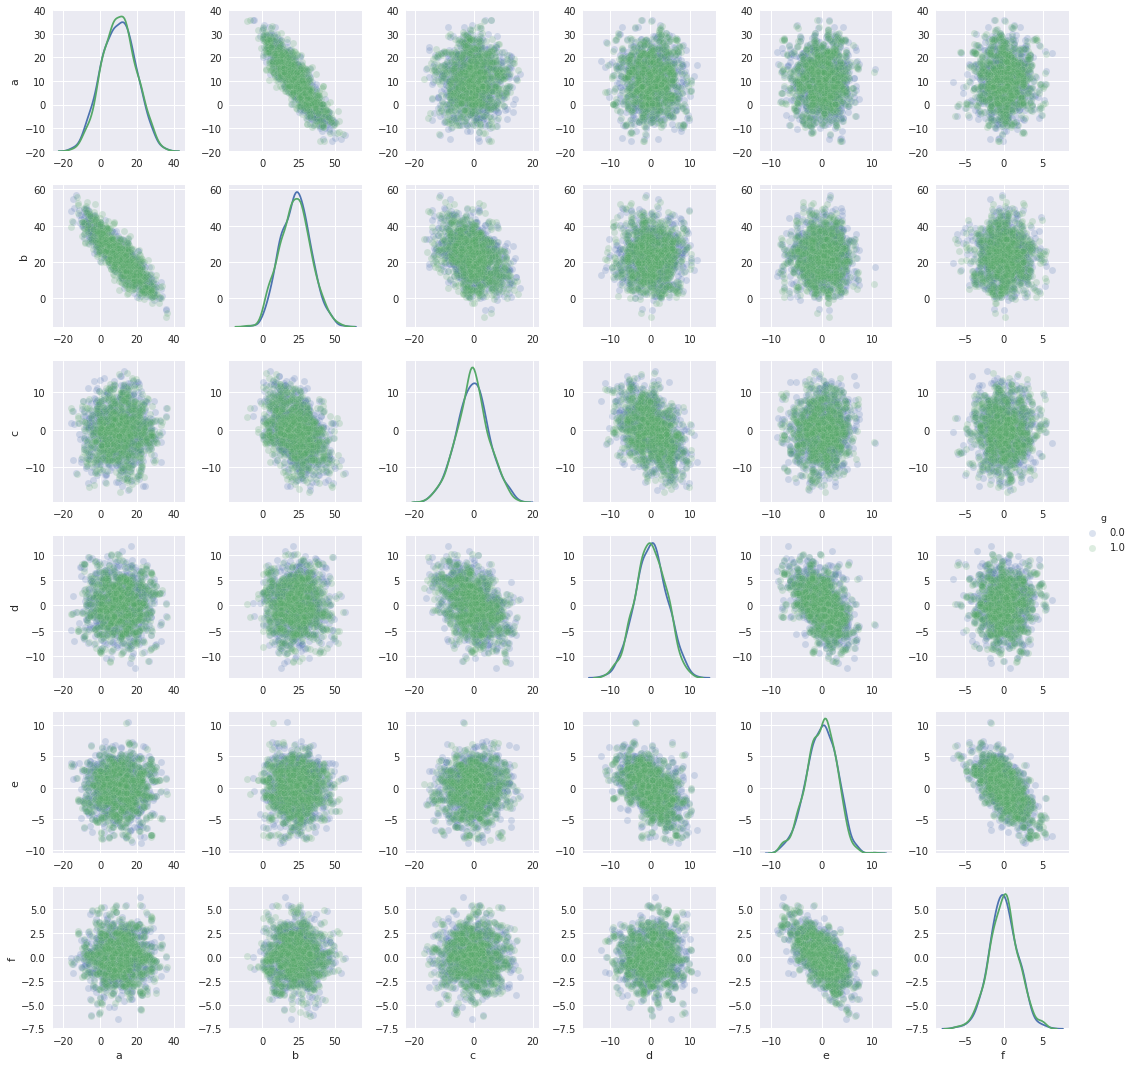

In [22]:
doublepairplot(x_train, x_post_sample.reshape(-1,6), D=D)
plt.show()

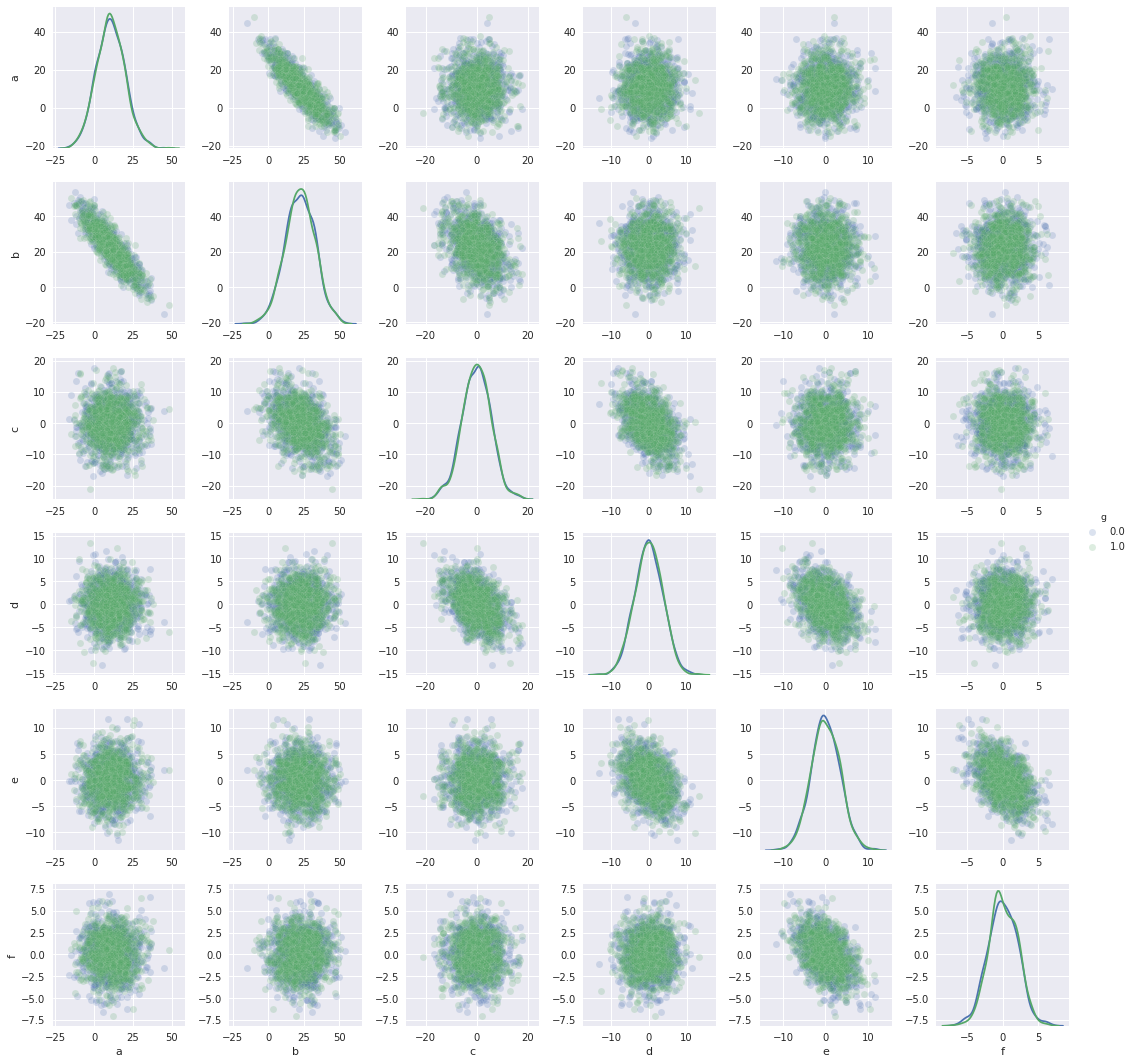

In [47]:
doublepairplot(x_train, x_sim_sample, D=D)
plt.show()

In [48]:
def KLgaussgauss(mu1,sigma1, mu2,sigma2):
    # only works for floating point input
    return np.log(sigma2/sigma1)+(sigma1**2+(mu1-mu2)**2)/2*sigma2**2-.5

In [49]:
def KLgaussstandardnormal(mu1,sigma1):
    return KLgaussgauss(mu1,sigma1,0,1)

In [51]:
w_true, sigma_true

(array([[ 9.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [-9.  ,  4.5 ,  0.  ,  0.  ,  0.  ],
        [ 0.  , -4.5 ,  3.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  , -3.  ,  2.25,  0.  ],
        [ 0.  ,  0.  ,  0.  , -2.25,  1.8 ],
        [ 0.  ,  0.  ,  0.  ,  0.  , -1.8 ]]),
 array([ 0.414,  0.651,  0.569,  0.198,  1.869,  1.079]))

In [52]:
KLgaussstandardnormal(qz.parameters['loc'].eval(),qz.parameters['scale'].eval())

array([[ 0.464,  0.003,  0.162,  0.264,  0.022,  1.865],
       [ 3.271,  0.289,  0.857,  1.573,  2.908,  0.97 ],
       [ 1.798,  2.494,  0.6  ,  0.17 ,  0.431,  0.097],
       ..., 
       [ 0.34 ,  0.677,  0.437,  0.388,  0.485,  0.691],
       [ 1.419,  0.499,  0.249,  0.121,  0.493,  0.777],
       [ 0.175,  1.31 ,  0.193,  0.012,  0.767,  0.188]], dtype=float32)

In [53]:
qsigma_modes = tf.exp(qsigma.get_variables()[0] - (tf.nn.softplus(qsigma.get_variables()[1])**2)).eval()

In [54]:
qwmode, qsigma_modes

(array([[-0.003,  2.951,  0.035,  0.793, -7.193,  0.012],
        [ 0.016, -3.335,  3.494,  0.846,  6.976,  0.008],
        [-0.002,  0.168, -5.201, -0.059,  0.785, -0.024],
        [ 0.001,  1.479,  1.77 , -2.084,  0.227,  0.002],
        [ 0.008, -2.892, -0.215, -0.156, -1.678,  0.003],
        [ 0.002,  0.881,  0.026,  0.497,  0.497, -0.001]], dtype=float32),
 array([ 0.051,  0.039,  0.675,  0.12 ,  0.388,  0.21 ], dtype=float32))

In [55]:
studentqwmode = student.Qmodel[2].mode().eval()

In [56]:
studentqwmode

array([[ 0.003,  0.002, -0.004,  0.01 ,  0.002, -0.007],
       [-0.001,  0.002, -0.013,  0.005,  0.012,  0.013],
       [ 0.015,  0.001, -0.013, -0.004, -0.001,  0.001],
       [-0.003,  0.001,  0.001,  0.015, -0.001, -0.009],
       [-0.008, -0.002,  0.008, -0.001, -0.02 , -0.003],
       [-0.003,  0.007, -0.011,  0.001,  0.015, -0.001]], dtype=float32)

In [57]:
studentqsigma_modes = tf.exp(student.Qmodel[-1].get_variables()[0] - (tf.nn.softplus(student.Qmodel[-1].get_variables()[1])**2)).eval()

In [58]:
studentqsigma_modes

array([  9.293,  10.782,   5.693,   3.751,   3.396,   2.136], dtype=float32)

In [59]:
KLgaussstandardnormal(student.Qmodel[3].parameters['loc'].eval(),student.Qmodel[3].parameters['scale'].eval())

array([[ 0.001,  0.003,  0.002,  0.002,  0.   ,  0.001],
       [ 0.   ,  0.003,  0.003,  0.002,  0.001,  0.   ],
       [ 0.001,  0.   ,  0.   ,  0.   ,  0.005,  0.004],
       ..., 
       [ 0.001,  0.   ,  0.   ,  0.001,  0.001,  0.003],
       [ 0.002,  0.   ,  0.005,  0.005,  0.002,  0.001],
       [ 0.005,  0.   ,  0.001,  0.001,  0.   ,  0.002]], dtype=float32)

In [60]:
def generator(arrays, batch_size):
    # assuming arrays is a list of arrays of equal length, with rows being observations
    while True:
        batches = []
        random_idx = np.random.choice(arrays[0].shape[0], batch_size, replace=False)
        for array in arrays:
            batches.append(array[random_idx])
        yield batches

In [61]:
data = generator([x_train], M)

In [62]:
next(data)[0]

array([[  6.117,  27.727,  -3.146,   3.942,  -2.024,   0.092],
       [  4.363,  33.489,   2.921,  -6.108,   0.701,   1.383],
       [ 10.631,  11.781,  12.868,  -0.416,  -1.981,   0.662],
       ..., 
       [  9.721,  25.857,  -4.798,   1.613,   2.917,  -1.25 ],
       [ 11.781,  22.065,  -0.7  ,  -1.214,  -0.355,  -1.91 ],
       [ 12.007,  14.637,   4.718,   2.818,  -1.087,   0.789]], dtype=float32)

In [63]:
next(data)[0]

array([[  9.515,  30.321,  -3.042,  -1.316,  -2.873,  -1.478],
       [ 17.88 ,  10.779,   3.227,   0.889,   6.696,  -1.365],
       [  4.926,  36.443,   6.028, -13.15 ,   1.433,  -1.067],
       ..., 
       [  9.476,  21.24 ,   3.154,  -1.597,  -3.877,   4.434],
       [ 10.094,  21.538,   2.621,  -2.038,   4.483,  -1.906],
       [ 21.039,   6.279,   2.553,  -0.772,   5.967,  -0.628]], dtype=float32)

In [65]:
next(data)[0].shape

(1000, 6)